<h3> Import Libraries </h3>

In [1]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import shutil
from PIL import Image

In [2]:
import pandas as pd
# import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
print(tf.__version__)
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
# import tensorflow_addons as tfa

2023-01-19 14:05:04.441199: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.0


In [4]:
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h3> Data preprocessing </h3>

In [6]:
def fft(img):
    img=np.array(img)
    f =np.fft.fft2(img.astype(np.float64)/255., axes=(0,1))
  
    # print(f.shape)
    fshift = np.fft.fftshift(f[...,0])
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # print(magnitude_spectrum.shape)
    # img_norm=(magnitude_spectrum-np.min(magnitude_spectrum))/(np.max(magnitude_spectrum)-np.min(magnitude_spectrum))
    return(magnitude_spectrum.reshape(magnitude_spectrum.shape[0],magnitude_spectrum.shape[1],1 ))
           
           


(250, 250, 1)


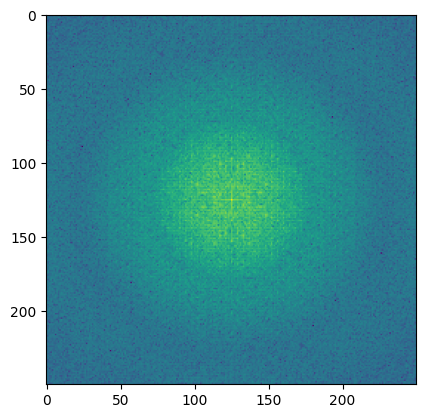

In [8]:
path='/data/Data_Shinjan/Atomagined/Real_Space/Training_raw/cubic/'
for file in os.listdir(path):
    img=plt.imread(path+file)
    img=fft(img)
    break
plt.imshow(img)
print(img.shape)

In [6]:
dataset_mean=np.array([0.278, 0.278, 0.278])
dataset_std=np.array([0.178, 0.178, 0.178])

def preprocess_real_space(img):
    img=img/255
    centered=np.subtract(img, dataset_mean)
    standardized=np.divide(centered, dataset_std)
    
    return standardized
    

In [7]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   # rescale=1/255,
                                   preprocessing_function=preprocess_real_space,
                                   # height_shift_range=0.05,
                                   # width_shift_range=0.05,
                                   # rotation_range=20,
                                   # zoom_range=0.05,
                                   # brightness_range=[0.9,1.1],
                                   # fill_mode='constant',
                                   horizontal_flip=True
                                                                            )
test_datagen = ImageDataGenerator(featurewise_center=False,
                                  featurewise_std_normalization=False,
                                  # rescale=1/255,
                                  preprocessing_function=preprocess_real_space
                                                                            )

In [8]:
train_generator = train_datagen.flow_from_directory('/data/Data_Shinjan/Atomagined/Real_Space/Training_raw_balanced/', 
                                                    target_size=(224, 224), 
                                                    class_mode= 'categorical', 
                                                    color_mode='rgb', 
                                                    batch_size=32,
                                                    interpolation ='lanczos'
                                                    )
validation_generator = test_datagen.flow_from_directory('/data/Data_Shinjan/Atomagined/Real_Space/Validation_raw_balanced/', 
                                                        target_size=(224, 224), 
                                                        class_mode= 'categorical',
                                                        color_mode='rgb', 
                                                        batch_size=32,
                                                        interpolation ='lanczos'
                                                        )

Found 5733 images belonging to 7 classes.
Found 1904 images belonging to 7 classes.


In [9]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(40,40))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

(32, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

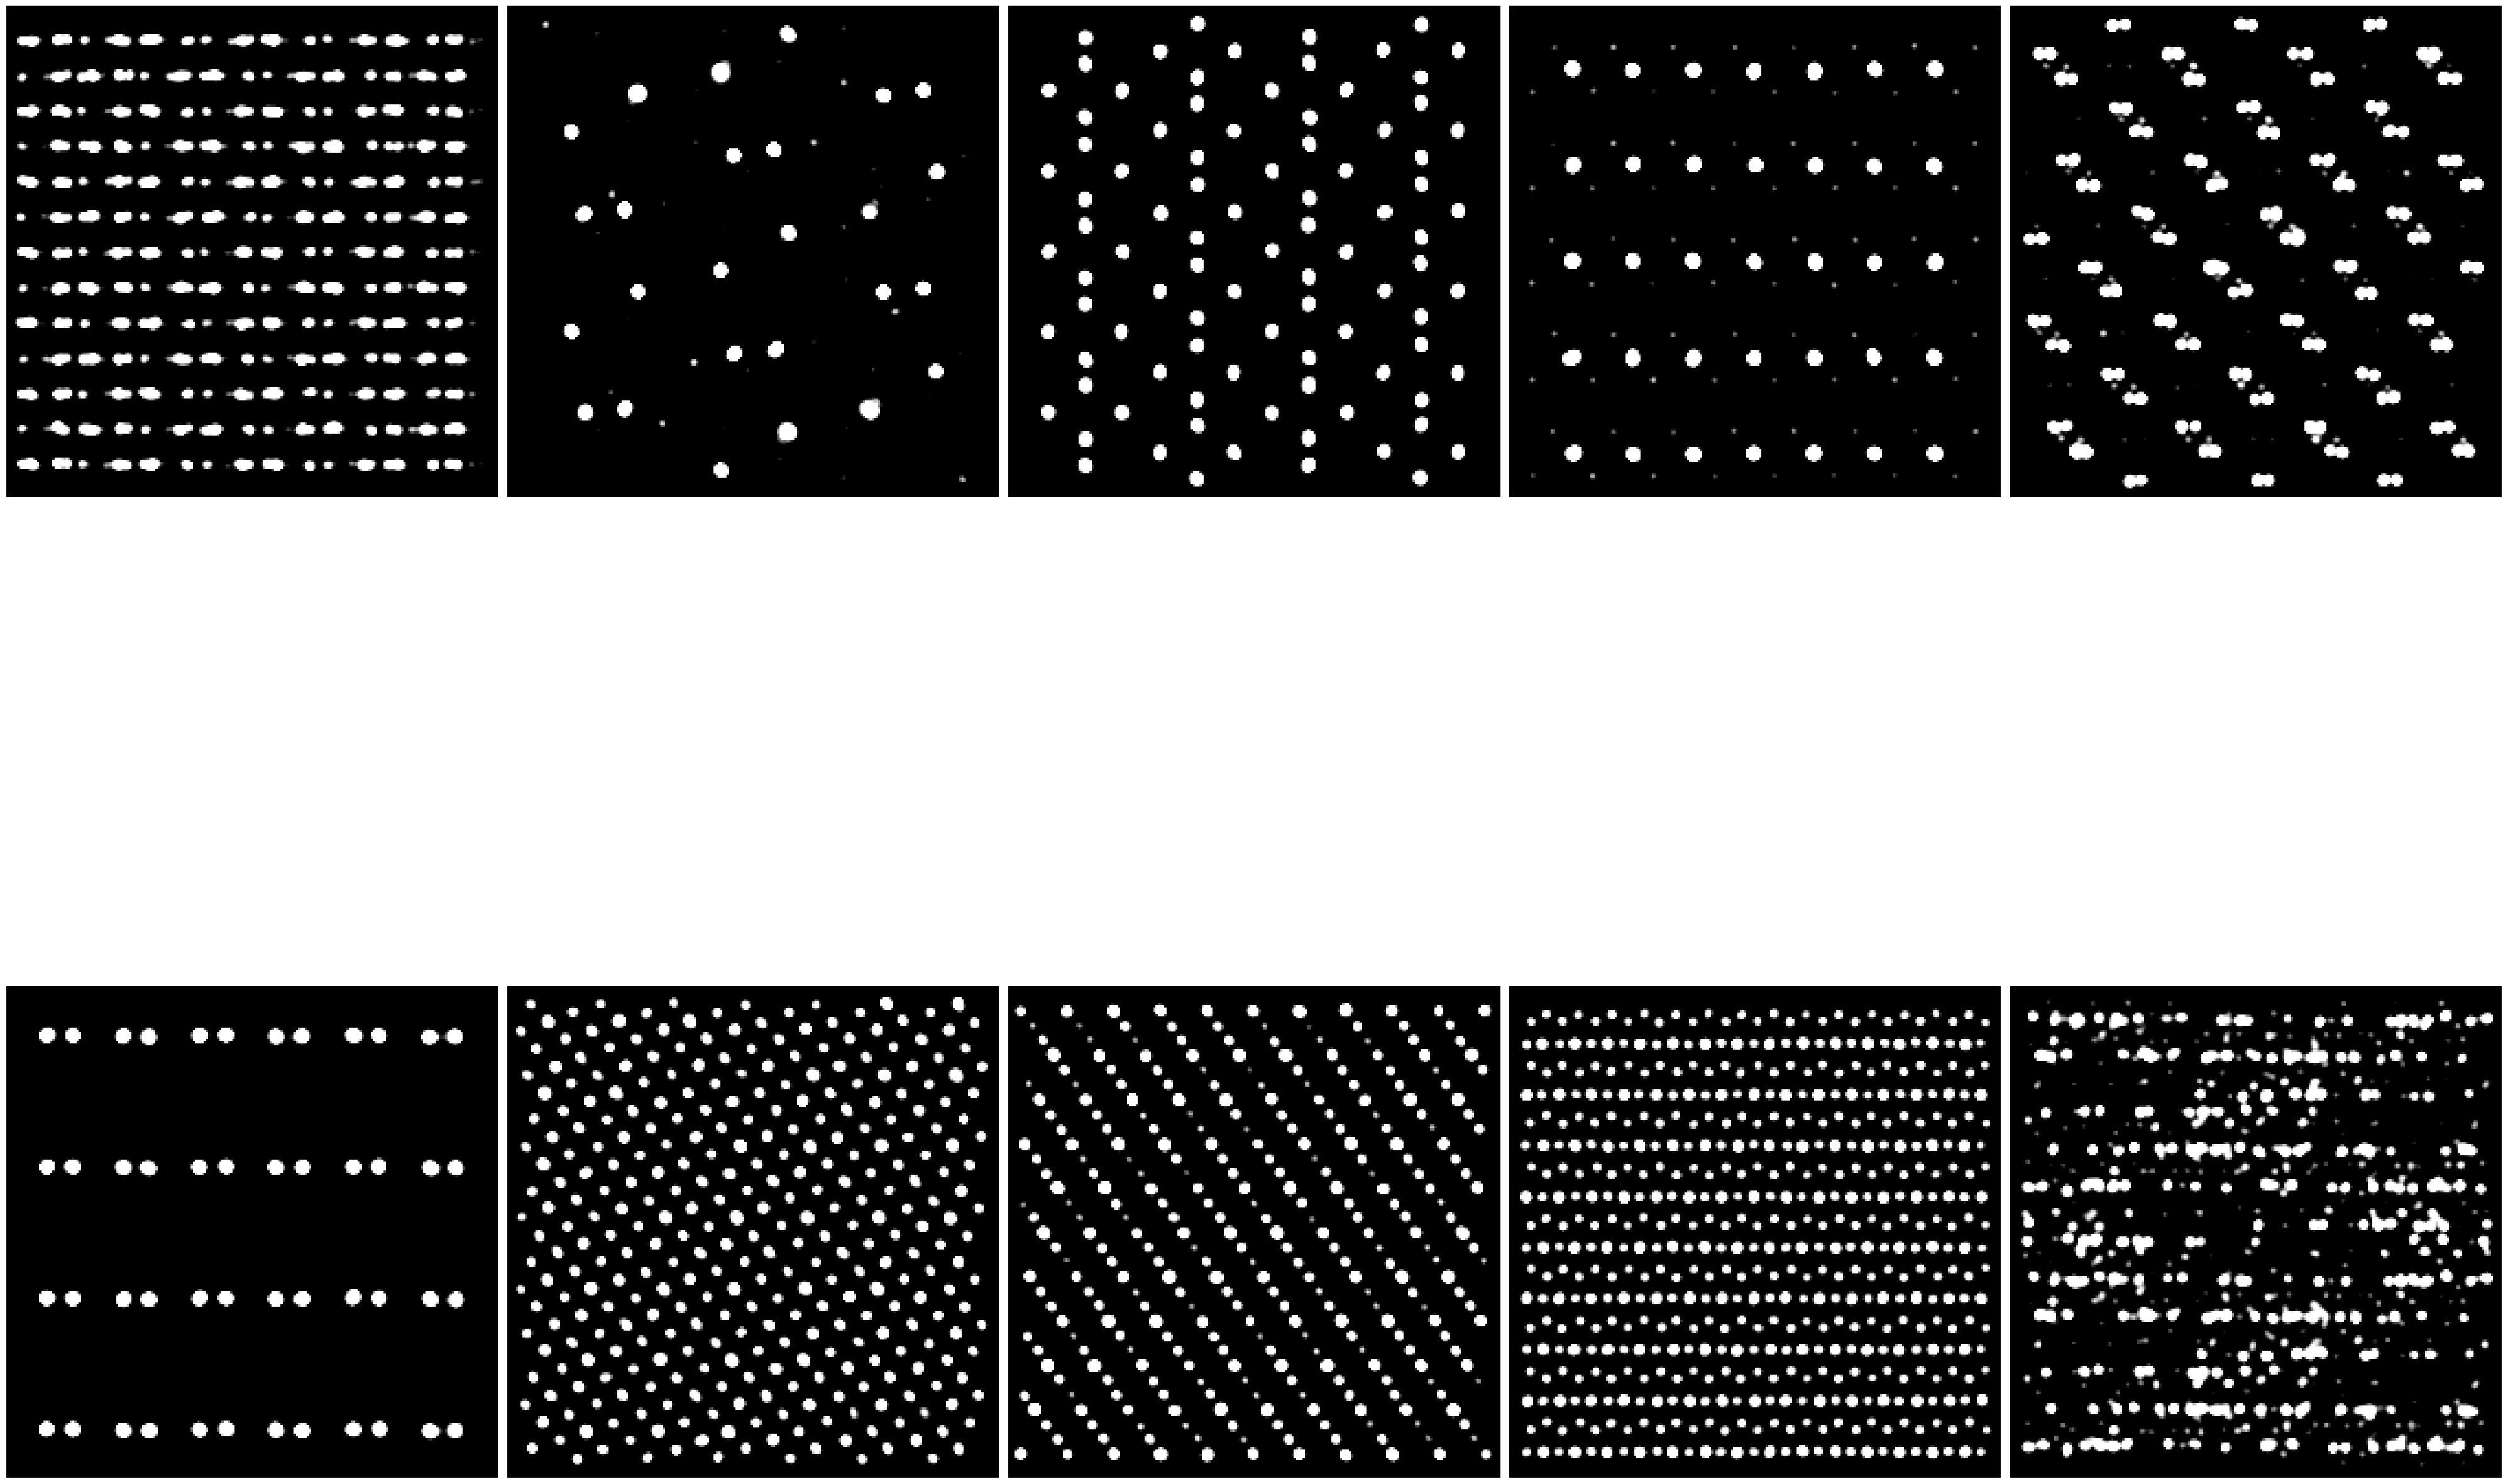

In [10]:
sample_training_images, _ = next(train_generator)
print(sample_training_images.shape)
# sample_training_images = np.multiply(sample_training_images, dataset_std)
# sample_training_images = np.add(sample_training_images, dataset_mean)
plotImages(sample_training_images)

### Build model

In [12]:
base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224,224,3),
        pooling=None,
        
        classifier_activation="softmax",
        )
x=base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(7, activation='softmax', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()




2023-01-19 14:06:30.287498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 14:06:31.157946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47223 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### Freeze Convolutional Base

In [13]:
for layer in model.layers[:423]:
   layer.trainable = False
for layer in model.layers[423:]:
   layer.trainable = True

In [14]:
# model.compile(optimizer='adam', loss='categorical_crossentropy')
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001, amsgrad=True, epsilon=1.0),
              metrics=['acc',                       
                     tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])
                     # tfa.metrics.MultiLabelConfusionMatrix(num_classes=7)])


In [15]:
es = EarlyStopping(monitor='val_auc', 
                   verbose=1, 
                   patience=5, 
                   min_delta=0.001, 
                   mode='max')
mc = ModelCheckpoint('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/', 
                     monitor='val_auc', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max',
                    save_weights_only=True)
rlr = ReduceLROnPlateau(monitor='val_auc',
                        mode='max',
                        factor=0.1,
                        patience=3)

In [29]:
# class_weights = {0: (40718/819)/7,        #cubic
#                 1: (40718/2269)/7,        #hexagonal
#                 2: (40718/15953)/7,       #monoclinic
#                 3: (40718/9712)/7,        #orthorhombic
#                 4: (40718/2529)/7,        #tetragonal
#                 5: (40718/6085)/7,        #triclinic
#                 6: (40718/3351)/7}        #trigonal

Epoch 1/50


2023-01-19 14:12:12.676434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


180/180 [==============================] - ETA: 0s - loss: 2.3171 - acc: 0.1362 - auc: 0.4927 - precision: 0.1561 - recall: 0.0159
Epoch 1: val_auc improved from -inf to 0.49527, saving model to /home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/
180/180 [==============================] - 85s 407ms/step - loss: 2.3171 - acc: 0.1362 - auc: 0.4927 - precision: 0.1561 - recall: 0.0159 - val_loss: 2.1265 - val_acc: 0.1371 - val_auc: 0.4953 - val_precision: 0.2549 - val_recall: 0.0068 - lr: 0.0010
Epoch 2/50
180/180 [==============================] - ETA: 0s - loss: 2.1147 - acc: 0.1479 - auc: 0.5169 - precision: 0.2154 - recall: 0.0098
Epoch 2: val_auc improved from 0.49527 to 0.52547, saving model to /home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/
180/180 [==============================] - 70s 389ms/step - loss: 2.1147 - acc: 0.1479 - auc: 0.5169 - precision: 0.2154 - recall: 0.0098 - val_loss: 2.0798 - val_acc: 0.1654 - val_auc: 0.5255 - val_precision: 0.3014 - 

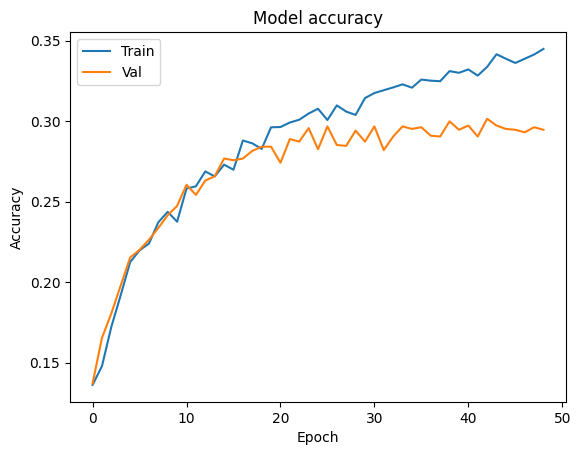

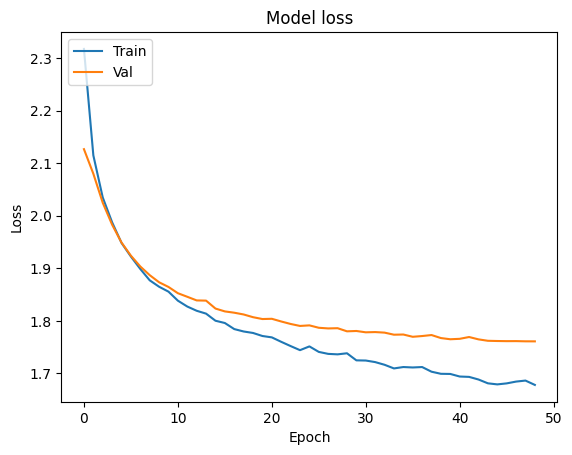

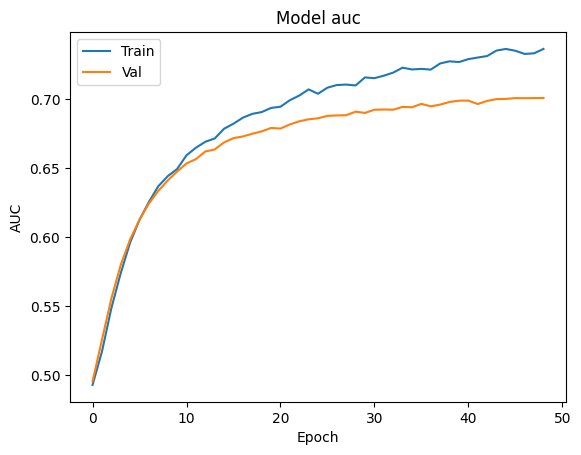

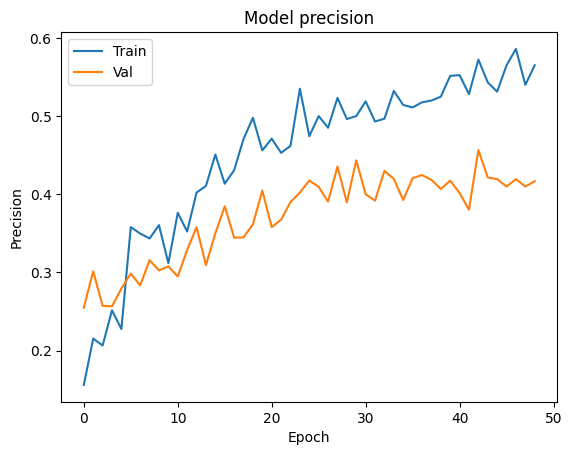

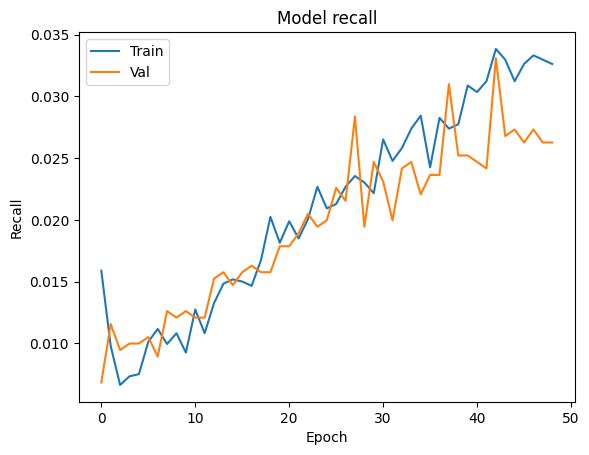

In [16]:
history= model.fit(train_generator, batch_size=32, epochs=50, validation_data=validation_generator, callbacks = [es, mc, rlr])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/loss.png')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/auc.png')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/precision.png')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/recall.png')
plt.show()

In [25]:
model.load_weights('/home/sdc4007/Atomagined/ModelCheckpoints/Real_Space_balanced/')

In [ ]:
model.load_weights('/global/cfs/cdirs/m2571/Shinjan/Atomagined/ModelCheckpoint/trial_FFT/')

In [ ]:
model.load_weights('/home/sdc4007/Atomagined/ModelCheckpoints/FFT_balanced_dataset/')

In [18]:
test_generator = test_datagen.flow_from_directory(directory='/data/Data_Shinjan/Atomagined/Real_Space/Testing_raw_balanced', 
                                                        target_size=(224,224), 
                                                        class_mode= 'categorical',
                                                        color_mode='rgb', 
                                                        batch_size=200,
                                                        interpolation='lanczos',
                                                       shuffle=False)

Found 1925 images belonging to 7 classes.


In [19]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

10/10 [==============================] - 25s 2s/step


In [20]:
import seaborn as sns

In [21]:
confusion = confusion_matrix(test_generator.classes, y_pred)

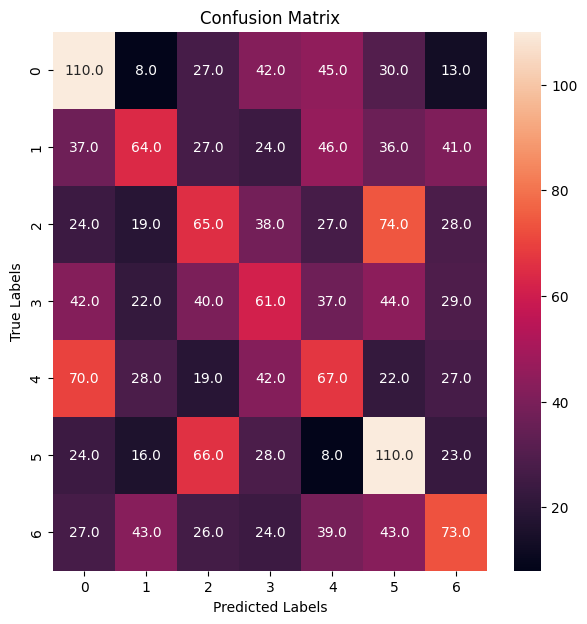

In [22]:
# Real Space Balanced dataset

f, ax = plt.subplots(figsize = (7,7))
sns.heatmap(confusion, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [28]:
scores=model.evaluate(test_generator)

10/10 [==============================] - 18s 2s/step - loss: 1.7705 - acc: 0.2857 - auc: 0.6962 - precision: 0.3885 - recall: 0.0281


In [32]:
# print('Model loss:', loss)
print('Test Accuracy:', accuracy)

Test Accuracy: [1.7705377340316772, 0.2857142984867096, 0.6961747407913208, 0.3884892165660858, 0.02805194817483425]


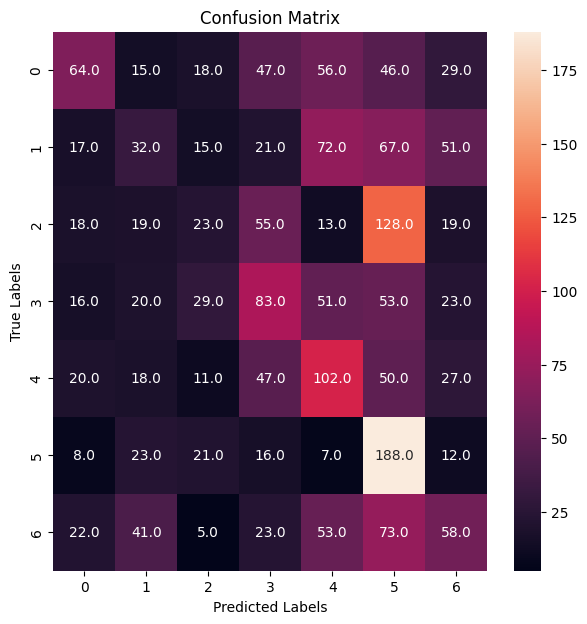

In [29]:
# FFT Balanced dataset

f, ax = plt.subplots(figsize = (7,7))
sns.heatmap(confusion, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

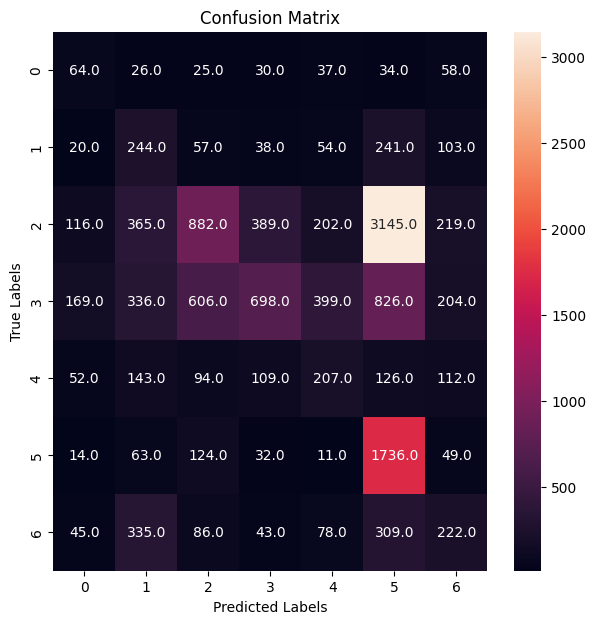

In [37]:
# FFT Unbalanced dataset

f, ax = plt.subplots(figsize = (7,7))
sns.heatmap(confusion, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();